In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime, timedelta, timezone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc

# PCA for anamoly detection

Data preparation for PCA

In [53]:
encoder = LabelEncoder()
labelled_data=pd.read_csv('./data/labeled_data.csv')
class_target_name = "Failure (Target)"
labelled_data=labelled_data.set_index('Timestamp')
labelled_data['Turbine_ID'] = encoder.fit_transform(labelled_data['Turbine_ID'])
scaled_features=labelled_data.drop(columns=[class_target_name,'components'])


pca = PCA(n_components=2)
pca.fit(scaled_features)
pca_projection = pca.transform(scaled_features)
    
    # Reconstruct the data from PCA space back to original space
reconstructed_data = pca.inverse_transform(pca_projection)
reconstruction_error = np.mean((scaled_features - reconstructed_data) ** 2, axis=1)
threshold = np.percentile(reconstruction_error, 52.5)

pca_projection = pca.transform(scaled_features)
reconstructed_data = pca.inverse_transform(pca_projection)
reconstruction_error = np.mean((scaled_features - reconstructed_data) ** 2, axis=1)
labelled_data['reconstruction_error'] = reconstruction_error
labelled_data['predicted_faulty'] = labelled_data['reconstruction_error'] > threshold
faulty_original_data = labelled_data[labelled_data['predicted_faulty'] == True]

# Evaluate the model
print(classification_report(labelled_data[class_target_name], labelled_data['predicted_faulty']))
print(f"Number of actual faulty instances: {labelled_data[class_target_name].sum()}")
print(f"Number of identified faulty instances: {labelled_data['predicted_faulty'].sum()}")
print(f"Number of correctly identified faulty instances: {faulty_original_data[class_target_name].sum()}")





              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1462
           1       0.55      0.55      0.55      1305

    accuracy                           0.58      2767
   macro avg       0.57      0.57      0.57      2767
weighted avg       0.58      0.58      0.58      2767

Number of actual faulty instances: 1305
Number of identified faulty instances: 1314
Number of correctly identified faulty instances: 722


In [65]:
train = pd.read_csv('./data/first_clean/train.csv')
train=train.set_index('Timestamp')
encoder=LabelEncoder()
train['Turbine_ID']=encoder.fit_transform(train['Turbine_ID'])


test = pd.read_csv('./data/first_clean/test.csv')
test=test.set_index('Timestamp')
test['Turbine_ID']=encoder.transform(test['Turbine_ID'])

#Drop the target column and the components column

class_target_name = "Failure (Target)"

train_non_faulty=train[train[class_target_name]==0]
X_train = train_non_faulty.drop(columns=[class_target_name,'components'])
X_test= test.drop(columns=[class_target_name,'components'])


y_failure_train=train_non_faulty[class_target_name]
y_failure_test=test[class_target_name]


y_component_train=train_non_faulty['components']
y_component_test=test['components']

#PCA

pca=PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  
X_train_reconstrcuted = pca.inverse_transform(X_train_pca)
reconstruction_error = np.mean((X_train - X_train_reconstrcuted) ** 2).mean()
threshold = reconstruction_error.mean() + 1.5 * reconstruction_error.std()
train_non_faulty['reconstrcution_error'] = reconstruction_error
train_non_faulty['predicted_faulty'] = train_non_faulty['reconstrcution_error'] > threshold
faulty_original_data = train_non_faulty[train_non_faulty['predicted_faulty'] == True]

print(classification_report(train_non_faulty[class_target_name], train_non_faulty['predicted_faulty']))
print(f"Number of actual faulty instances: {train_non_faulty[class_target_name].sum()}")
print(f"Number of identified faulty instances: {train_non_faulty['predicted_faulty'].sum()}")
print(f"Number of correctly identified faulty instances: {faulty_original_data[class_target_name].sum()}")

#Test data
X_test_pca = pca.transform(X_test)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
reconstruction_error = ((X_test - X_test_reconstructed) ** 2).mean(axis=1)
test['reconstruction_error'] = reconstruction_error
test['predicted_faulty'] = test['reconstruction_error'] > threshold
faulty_original_data_test = test[test['predicted_faulty'] == True]

print(classification_report(test[class_target_name], test['predicted_faulty']))
print(f"Number of actual faulty instances: {test[class_target_name].sum()}")
print(f"Number of identified faulty instances: {test['predicted_faulty'].sum()}")
print(f"Number of correctly identified faulty instances: {faulty_original_data_test[class_target_name].sum()}")



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175

    accuracy                           1.00      1175
   macro avg       1.00      1.00      1.00      1175
weighted avg       1.00      1.00      1.00      1175

Number of actual faulty instances: 0
Number of identified faulty instances: 0
Number of correctly identified faulty instances: 0
              precision    recall  f1-score   support

           0       0.59      0.76      0.66       287
           1       0.62      0.42      0.50       267

    accuracy                           0.60       554
   macro avg       0.60      0.59      0.58       554
weighted avg       0.60      0.60      0.58       554

Number of actual faulty instances: 267
Number of identified faulty instances: 180
Number of correctly identified faulty instances: 112


/var/folders/7b/1zsp53s91z97clkc70s5xcym0000gn/T/ipykernel_17560/1429712394.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_non_faulty['reconstrcution_error'] = reconstruction_error
/var/folders/7b/1zsp53s91z97clkc70s5xcym0000gn/T/ipykernel_17560/1429712394.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_non_faulty['predicted_faulty'] = train_non_faulty['reconstrcution_error'] > threshold


In [66]:
print(test.shape)

(554, 108)


In [62]:
# confusion matrix
conf_matrix = confusion_matrix(test[class_target_name], test['predicted_faulty'])

<Axes: >

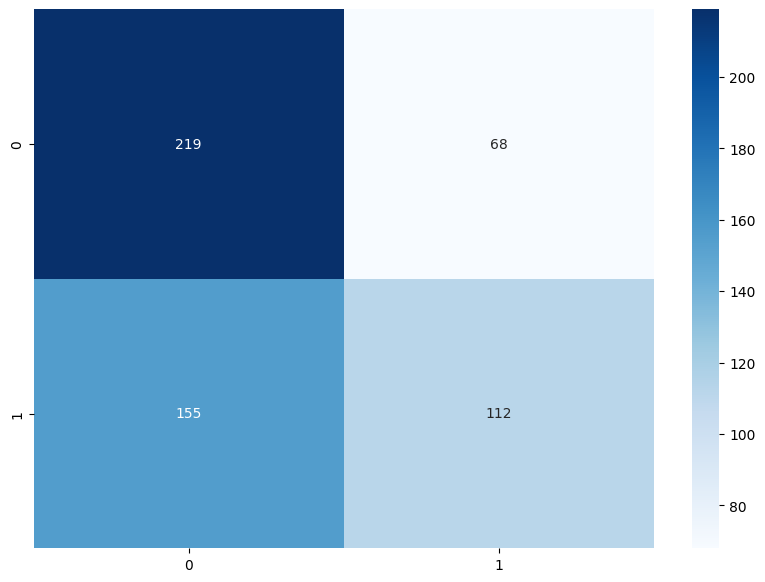

In [64]:
#plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

In [68]:
test.to_csv('./data/test_anamoly.csv', index=False)